In [14]:
import torch
import torchvision
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import re # re module for regular expressions
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import time
import random
from PIL import Image
from tqdm import tqdm
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import GradScaler, autocast

# makes this  determinsitic
torch.manual_seed(3407)
random.seed(3407)
np.random.seed(3407)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark = False


# ***** Check if CUDA (GPU support) is available *****
if torch.cuda.is_available():
    # Get the number of available CUDA devices (GPUs)
    num_cuda_devices = torch.cuda.device_count()

    # Iterate through each CUDA device and print its properties
    for i in range(num_cuda_devices):
        device_properties = torch.cuda.get_device_properties(i)
        print(f"CUDA Device {i} - Name: {device_properties.name}, CUDA Cores: {device_properties.multi_processor_count * 128}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("RUNNING ON ", device) # should be cuda

CUDA Device 0 - Name: NVIDIA RTX A5000, CUDA Cores: 8192
RUNNING ON  cuda


In [15]:
# ***** Model parameters *****

NUM_EPOCHS= 50
EARLY_STOPPING_LIMIT = 5
TEST_VAL_SPLIT = 0.75   # Split Dataframe into Test and Validation
NUM_CLASSES = 2         # Neurons at the output layer
BATCHSIZE = 192         # 256 is too big for GPU :-)
LR=1e-4                 # Learning rate
LRD_STEP_SIZE = 10      # Period of learning rate decay. Default 10
LRD_GAMMA = 0.1         # Multiplicative factor of learning rate decay. Default: 0.1
DROPOUT_RATE= 0.3       # probability of an element to be zeroed. Default: 0.5

# ***** Define Datapaths *****

IMAGE_FOLDER = "/data/AffectNet/train_set/images/"
IMAGE_FOLDER_TEST = "/data/AffectNet/val_set/images/"
CSV_PATH = "../dataset/train_set_annotation.csv"
CSV_PATH_TEST = "../dataset/val_set_annotation.csv"

Random Train/Val data:


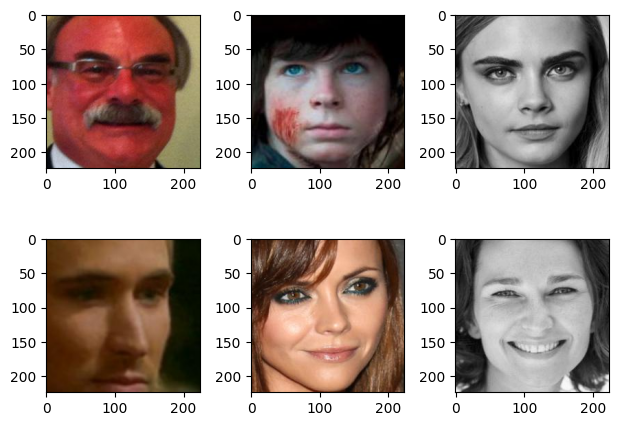

In [16]:
# ***** Inspect random data *****

print(f"Random Train/Val data:")

fig = plt.figure()
train_val_root = IMAGE_FOLDER
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(Image.open(train_val_root + sorted(os.listdir(train_val_root))[i]))

plt.show()

In [17]:
# ***** Read the csv with the image data *****

def remove_random_rows_by_class(df, class_value, fraction_to_remove):
    # Filter rows where 'exp' column equals the specified class
    class_rows = df[df['exp'] == class_value]

    # Calculate the number of rows to remove from the selected class
    num_rows_to_remove = int(len(class_rows) * fraction_to_remove)

    # Generate random indices to remove from the selected class
    random_indices = np.random.choice(class_rows.index, size=num_rows_to_remove, replace=False)

    # Exclude the randomly selected rows from the selected class
    updated_df = df.drop(random_indices)

    return updated_df


df = pd.read_csv(CSV_PATH)
df_test = pd.read_csv(CSV_PATH_TEST)

df.rename(columns=df.iloc[0])
df_test.rename(columns=df.iloc[0])

# ***** An easy non-intelligent way to rebalance *****
df = remove_random_rows_by_class(df=df, class_value = 0, fraction_to_remove= 0.94) # Class 0 has no direct correlation to Val and Aro, remove the class
df = remove_random_rows_by_class(df=df, class_value = 1, fraction_to_remove= 0.93) # Too many examples
df = remove_random_rows_by_class(df=df, class_value = 2, fraction_to_remove= 0.75) # Too many examples
df = remove_random_rows_by_class(df=df, class_value = 6, fraction_to_remove= 0.73) # Too many examples
df = remove_random_rows_by_class(df=df, class_value = 3, fraction_to_remove= 0.55) # Too many examples
df = remove_random_rows_by_class(df=df, class_value = 4, fraction_to_remove= 0.03) # Too many examples

df['aro'] = df['aro'] * 100
df['val'] = df['val'] * 100
df_test['aro'] = df_test['aro'] * 100
df_test['val'] = df_test['val'] * 100


df_train = df.sample(frac=TEST_VAL_SPLIT, random_state=42)
df_val = df.drop(df_train.index)

# Print the data based on the class 
print(f"Dataframe ingesamt: {df['exp'].value_counts()}")
print(f"Trainingsset: {df_train['exp'].value_counts()}")
print(f"Validationset: {df_val['exp'].value_counts()}")

labels = df[['val', 'aro']].values # define the labels 'Val' and 'Aro' for the model

df.head()

Dataframe ingesamt: exp
1    9410
6    6719
2    6365
3    6341
4    6187
0    4493
5    3803
7    3750
Name: count, dtype: int64
Trainingsset: exp
1    7069
6    5046
2    4762
3    4739
4    4692
0    3381
5    2856
7    2756
Name: count, dtype: int64
Validationset: exp
1    2341
6    1673
2    1603
3    1602
4    1495
0    1112
7     994
5     947
Name: count, dtype: int64


,number,exp,val,aro
10,18,6,-37.3016,81.7460
18,33,3,30.9524,36.5079
22,39,0,-40.2081,26.0170
30,49,3,32.3770,52.7994
32,52,6,-42.0635,87.3016


In [18]:
# ***** Create custom dataset and dataloader for the model *****

class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, balance=True):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.balance = balance

        if self.balance:
            # Balance the dataset by sampling the same number of samples for each class
            self.dataframe = self.balance_dataset()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, f"{self.dataframe['number'].iloc[idx]}.jpg")

        if os.path.exists(img_name):
            image = Image.open(img_name)
        else:
            image = Image.new('RGB', (224, 224), color='white') # Handle missing image file

        labels = torch.tensor(self.dataframe.iloc[idx, 2:4].values, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, labels

    def balance_dataset(self):
        # Group dataframe by the 'exp' column and sample the same number of samples for each class
        balanced_df = self.dataframe.groupby('exp', group_keys=False).apply(lambda x: x.sample(self.dataframe['exp'].value_counts().min()))
        return balanced_df

# Data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.ElasticTransform(alpha=5.0, sigma=5.0),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    # transforms.RandomGrayscale(p=0.25),
    # transforms.RandomRotation(degrees=15),
    # transforms.ColorJitter(0.15, 0.15, 0.15),
    # torchvision.transforms.RandomAutocontrast(p=0.4),
    #transforms.RandomHorizontalFlip(0.3),
    #transforms.CenterCrop(210),
    #torchvision.transforms.RandomAutocontrast(p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Standard ImageNet values
    #transforms.Normalize(mean=[0.569, 0.446, 0.391], std= [0.274, 0.244, 0.238]) # Our calculated Values from Affect Dataset
])

transform_test= transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.CenterCrop(210),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Standard ImageNet values
    #transforms.Normalize(mean=[0.569, 0.446, 0.391], std= [0.274, 0.244, 0.238]) # Our calculated Values from Affect Dataset
])

# Create the datasets
train_dataset= CustomDataset(dataframe=df_train, root_dir=IMAGE_FOLDER, transform=transform, balance=False)
val_dataset = CustomDataset(dataframe=df_val, root_dir=IMAGE_FOLDER, transform=transform_test, balance=False)
test_dataset = CustomDataset(dataframe=df_test, root_dir=IMAGE_FOLDER_TEST, transform=transform_test, balance=False)

#train_dataset, val_dataset, test_dataset = random_split(custom_dataset_balanced, [train_size, val_size, test_size])

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True, num_workers=48)
val_loader = DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=True, num_workers=48)
test_loader = DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False, num_workers=48)

print('Length of train_dataset: ', len(train_dataset), ' ; Length of val_dataset: ', len(val_dataset), ' ; Length of test_dataset: ', len(test_dataset))


Length of train_dataset:  35301  ; Length of val_dataset:  11767  ; Length of test_dataset:  3999


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


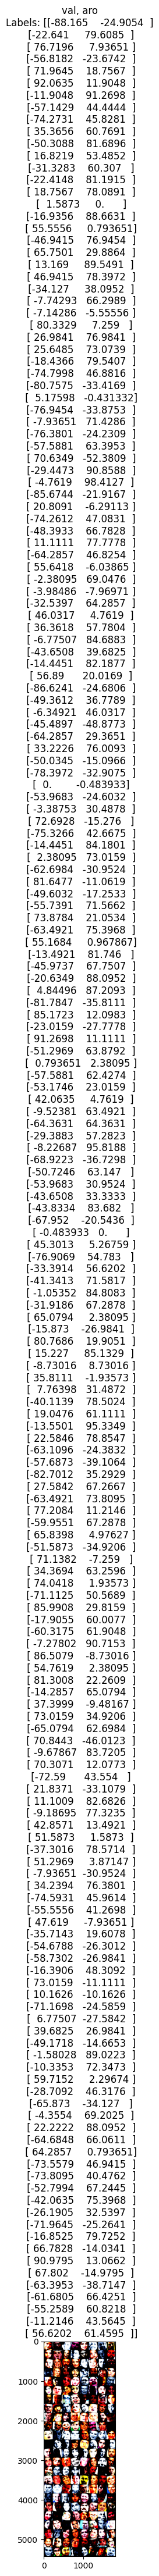

In [19]:
# ***** Test and visualize the train loader *****

def vis_batch(loader, header=""):
    def show(inp, label):
        fig = plt.gcf()
        plt.imshow(inp.permute(1, 2, 0))
        plt.title(label)
        print(loader)
    for batch_inputs, labels in loader:
        # Move inputs and labels to the device (GPU)
        batch_inputs, labels = batch_inputs.to(device), labels.to(device)

        grid = torchvision.utils.make_grid(batch_inputs.cpu())  # Move to CPU for visualization
        show(grid, label=f'{header}\nLabels: {labels.cpu().numpy()}')
        # plt.show()
        break

vis_batch(train_loader, header="val, aro")

In [20]:
# ***** SwinT V2 model *****
# !! At the moment the EfficientNet model is better !!

class CustomModel(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(CustomModel, self).__init__()
        self.base_model = models.swin_v2_s(weights='DEFAULT')#.to(device)

        # To only train the classifier of the model:
        # for param in self.base_model.parameters():  # We don't want to change the learned ImageNet weights. Disable gradient calculation for CNN
        #    param.requires_grad = False

        n_inputs = self.base_model.head.in_features
        self.base_model.head = nn.Sequential(
            nn.Linear(n_inputs, num_classes),
        )

    def forward(self, x):
        x = self.base_model(x)
        return x

#model = CustomModel(num_classes= NUM_CLASSES, dropout_rate=DROPOUT_RATE) # Initialize model

In [21]:
# ***** Custom EfficientNet V2 model *****
# !! So far the best !!

base_model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.DEFAULT)
num_features = base_model.classifier[1].in_features
base_model.classifier[1] = nn.Linear(in_features=num_features, out_features=NUM_CLASSES)  # Adjust classifier layer

model = base_model # Initalize the model
model= nn.DataParallel(model) # For multiple GPUs
model.to(device)

DataParallel(
  (module): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(

In [23]:
# ***** ResNet-18 *****

base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_features = base_model.fc.in_features
base_model.fc = nn.Linear(in_features=num_features, out_features=NUM_CLASSES)  # Adjust classifier layer

model = base_model # Initalize the model
model= nn.DataParallel(model) # For multiple GPUs
model.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
# ***** model and training parameters *****

# Define loss function and optimizer with weight decay
class CustomLoss(nn.Module):
    def __init__(self, sign_penalty_weight=0.1):
        super(CustomLoss, self).__init__()
        self.sign_penalty_weight = sign_penalty_weight

    def forward(self, predictions, targets):
        # Mean Squared Error (MSE) loss
        mse_loss = nn.functional.mse_loss(predictions, targets)

        # Penalty for wrong sign (excluding zero)
        sign_penalty = torch.mean(torch.relu(-predictions * targets) * torch.sign(targets)) * self.sign_penalty_weight
        
        # Total loss
        total_loss = mse_loss + sign_penalty

        return total_loss

# Define a function to filter parameters
def filter_params(params, include_patterns, exclude_patterns):
    included_params = []
    excluded_params = []
    for name, param in params:
        if any(re.search(pattern, name) for pattern in include_patterns):
            included_params.append(param)
        elif not any(re.search(pattern, name) for pattern in exclude_patterns):
            excluded_params.append(param)
    return included_params, excluded_params
    
# Define patterns to include/exclude BatchNorm parameters
include_patterns = [r'^(?!.*\.bn)']  # Match any layer name that doesn't contain '.bn' 
exclude_patterns = [r'.*\.bn.*']

# Filter parameters for weight decay and no weight decay
params_to_decay, params_not_to_decay = filter_params(model.named_parameters(), include_patterns, exclude_patterns)

# Create optimizer with different weight decay for different parameter groups
# optimizer = torch.optim.AdamW(model.base_model.head.parameters(), lr=LR)
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer = optim.AdamW([
    {'params': params_to_decay, 'weight_decay': 0.2},  # Apply weight decay to these parameters
    {'params': params_not_to_decay, 'weight_decay': 0.0}  # Exclude weight decay for these parameters
], lr=LR)


scheduler = exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=LRD_STEP_SIZE, gamma=LRD_GAMMA)
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = BATCHSIZE*NUM_EPOCHS)
#scaler = GradScaler()
criterion = nn.SmoothL1Loss()
#criterion = CustomLoss(sign_penalty_weight=0.1)

: 

In [ ]:
# **** Training ****

print("Start training:")

start = time.time()
early_stopping_counter = 0
previous_val_loss = np.inf
best_val_loss = previous_val_loss

# For plotting
train_loss_history = []
valid_loss_history = []
fig = plt.figure() # For a figur of the training


# model.load_state_dict(torch.load('checkpoint.pt'))   # loading best weights

for epoch in tqdm(range(NUM_EPOCHS)):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        # From the past semester:
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(images)
            loss = criterion(outputs.cuda(), labels.cuda())
            #scaler.scale(loss).backward()
            #lr_scheduler.step()
            #scaler.step(optimizer)
            #scaler.update()
            #current_lr = optimizer.param_groups[0]['lr']

        # Niklas:
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            lr_scheduler.step()

    scheduler.step()

    train_loss_history.append(loss.item())

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

    average_val_loss = val_loss / len(val_loader)
    valid_loss_history.append(average_val_loss)

    # Early stopping
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(),"checkpoint.pt")   # saving best weights so far
    else:
        early_stopping_counter += 1
        if early_stopping_counter == EARLY_STOPPING_LIMIT:
            print("*" * 70)
            model.load_state_dict(torch.load('checkpoint.pt'))      # loading best weights
            print(f"Early-Stopping activated: Using weights from epoch {epoch+1-EARLY_STOPPING_LIMIT}")
            print(f"Result: Validation Loss =  {best_val_loss:.4f}")
            plt.axvline(epoch+1-EARLY_STOPPING_LIMIT, label="Early Stopping", color='r')
            break

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {loss.item()}, Validation Loss: {average_val_loss}, Early Stopping Counter: {early_stopping_counter}, Timestamp: {round(time.time() - start)} seconds')

# Print loss curves
plt.plot(range(1,1+len(train_loss_history)),train_loss_history, label="Training Loss")
if len(train_loss_history) == len(valid_loss_history):
    plt.plot(range(1,1+len(valid_loss_history)),valid_loss_history, label="Validation Loss")
else:
    plt.plot(range(0,len(valid_loss_history)),valid_loss_history, label="Validation Loss")

plt.legend()
plt.show()


print(f"This took {round(time.time() - start)} seconds")

: 

In [ ]:
# ***** Test and visualize the performance on the test set *****

def test_and_visualize(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    predictions = []
    targets = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            test_loss += criterion(outputs, labels).item()

            predictions.append(outputs.cpu().numpy())
            targets.append(labels.cpu().numpy())

    average_test_loss = test_loss / len(test_loader)

    # Convert lists to numpy arrays
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)

    # Display performance metrics or visualizations as needed
    print(f'Test Loss: {average_test_loss}')

    return predictions, targets

def count_within_margin(predictions, targets, margin):
    predictions = np.array(predictions)
    targets = np.array(targets)

    # Calculate the absolute difference between predictions and targets
    differences = np.abs(predictions - targets)

    # Count how many values are within and outside the margin
    within_margin = np.sum(differences <= margin)
    outside_margin = len(predictions)*2 - within_margin

    print(40*'*')
    print(f"Number of values within the margin of {margin} for Val and Aro: {within_margin}")
    print(f"Number of values outside the margin of {margin} for Val and Aro: {outside_margin}")
    print(f"Success quote of the prediction: {round(within_margin*100/(within_margin+outside_margin),2)}%")

    return within_margin, outside_margin


# Test the model and visualize the performance
predictions, targets = test_and_visualize(model, test_loader, criterion)

predictions = predictions / 100
targets = targets / 100
margin = 0.25

count_within_margin(predictions, targets, 0.5)
count_within_margin(predictions, targets, 0.375)
count_within_margin(predictions, targets, margin)


# Example: Plotting predicted vs. actual values
x_target= [-1.5, 1.5]
y_target= [-1.5,1.5]
y_target = np.array(y_target)

# Example: Plotting predicted vs. actual values for 'val'
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(x_target, y_target, linestyle='--', label='target', color='red')
plt.plot(x_target, y_target + margin, linestyle='--', label='target + '+str(margin), color='green')
plt.plot(x_target, y_target - margin, linestyle='--', label='target - '+str(margin), color='green')

plt.scatter(targets[:, 0], predictions[:, 0], label='val', alpha=0.125)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values (val)')
plt.xlim(-1.05, 1.05)
plt.ylim(-1.05, 1.05)
plt.legend()

# Example: Plotting predicted vs. actual values for 'aro'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(x_target, y_target, linestyle='--', label='target', color='red')
plt.plot(x_target, y_target + margin, linestyle='--', label='target + '+str(margin), color='green')
plt.plot(x_target, y_target - margin, linestyle='--', label='target - '+str(margin), color='green')

plt.scatter(targets[:, 1], predictions[:, 1], label='aro', color='orange', alpha=0.125)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values (aro)')
plt.xlim(-1.05, 1.05)
plt.ylim(-1.05, 1.05)
plt.legend()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


plt.savefig('./plots/EffNet_V2_M_AdamWcustom_L1Loss_BalancedData'+ str(NUM_EPOCHS) +'EPOCHS_'+ str(BATCHSIZE) +'BATCHSIZE_' +str(LR) + 'LR_' + str(LRD_GAMMA) + 'GAMMA_' + str(len(train_dataset)) + 'SIZETRAINDATA_' + '.png')

: 